In [1]:
# import libraries
# public data
import yfinance as yf
# data manipulation
import pandas as pd
import numpy as np
# plotting
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 8)
plt.style.use('fivethirtyeight')
# pre-processing
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit, cross_val_score
# classifier
from sklearn.neighbors import KNeighborsClassifier
# metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import plot_confusion_matrix, auc, roc_curve, plot_roc_curve
# backtest
import pyfolio as pf
# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# load data
df = yf.download('SPY', start='2000-01-01', progress=False)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1999-12-31,146.84375,147.50000,146.250000,146.8750,97.509415,3172700
2000-01-03,148.25000,148.25000,143.875000,145.4375,96.555077,8164300
2000-01-04,143.53125,144.06250,139.640625,139.7500,92.779160,8089800
2000-01-05,139.93750,141.53125,137.250000,140.0000,92.945145,12177900
2000-01-06,139.62500,141.50000,137.750000,137.7500,91.451393,6227200


In [3]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,5643.000000,5643.000000,5643.000000,5643.000000,5643.000000,5.643000e+03
mean,182.152682,183.228916,180.960010,182.153289,156.855417,1.099045e+08
std,91.630430,92.043257,91.142563,91.634900,99.925350,9.493237e+07
min,67.949997,70.000000,67.099998,68.110001,52.636528,1.436600e+06
25%,118.094997,118.839996,117.134998,117.990002,86.424694,4.962065e+07
50%,141.979996,142.630005,140.937500,141.839996,108.034721,8.185240e+07
75%,218.090004,218.629997,217.379997,218.114998,196.950233,1.443024e+08
max,479.220001,479.980011,476.059998,477.709991,476.230530,8.710263e+08


In [4]:
# check missing values
df.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [5]:
# predictors
df['O-C'] = df.Open - df.Close
df['H-L'] = df.High - df.Low
X = df[['O-C','H-L']].values
X[:5]

array([[-0.03125 ,  1.25    ],
       [ 2.8125  ,  4.375   ],
       [ 3.78125 ,  4.421875],
       [-0.0625  ,  4.28125 ],
       [ 1.875   ,  3.75    ]])

In [6]:
# target
# rule: if tomorrow's closing price is greater than the 0.995 of today's trading price, then we will buy and otherwise sell
y = np.where(df['Adj Close'].shift(-1)>0.995*df['Adj Close'],1,-1)
y

array([-1, -1,  1, ...,  1, -1, -1])

In [7]:
y.shape

(5643,)

In [8]:
pd.Series(y).value_counts()

 1    4282
-1    1361
dtype: int64

In [9]:
# split data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False) #always keep shuffle=false for fts
print(f"train and test size {len(X_train)}, {len(X_test)}")

train and test size 4514, 1129


In [10]:
# fit model

pipe = Pipeline([
    ("scaler", MinMaxScaler()),
    ("classifier", KNeighborsClassifier()) # default n = 5
])
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('classifier', KNeighborsClassifier())])

In [11]:
# target classes
class_names = pipe.classes_
class_names

array([-1,  1])

In [12]:
# predict model
y_pred = pipe.predict(X_test)

In [13]:
# metrics
acc_train = accuracy_score(y_train, pipe.predict(X_train))
acc_test = accuracy_score(y_test, y_pred)

In [14]:
print(f'train accuracy: {acc_train: 0.4}, "test accuracy:" {acc_test: 0.4}')

train accuracy:  0.7884, "test accuracy:"  0.6749


In [15]:
# predict prob
probs = pipe.predict_proba(X_test)
probs[:10]

array([[0. , 1. ],
       [0. , 1. ],
       [0.2, 0.8],
       [0. , 1. ],
       [0.2, 0.8],
       [0.4, 0.6],
       [0.4, 0.6],
       [0.4, 0.6],
       [0.2, 0.8],
       [0.4, 0.6]])

In [16]:
y_pred[:10]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

66 196 171 696


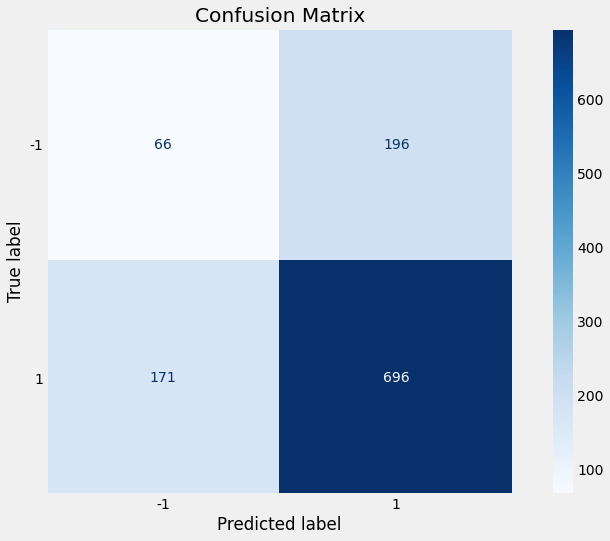

In [17]:
# confusion matrix (performance of classification model)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print(tn, fp, fn, tp)
# plot
plot_confusion_matrix(pipe, X_test, y_test, cmap='Blues', values_format='.4g')
plt.title('Confusion Matrix')
plt.grid(False)

In [18]:
# classification report (quality of predictions from a classification algo)
print(classification_report(y_test, y_pred))
# 23.40

              precision    recall  f1-score   support

          -1       0.28      0.25      0.26       262
           1       0.78      0.80      0.79       867

    accuracy                           0.67      1129
   macro avg       0.53      0.53      0.53      1129
weighted avg       0.66      0.67      0.67      1129



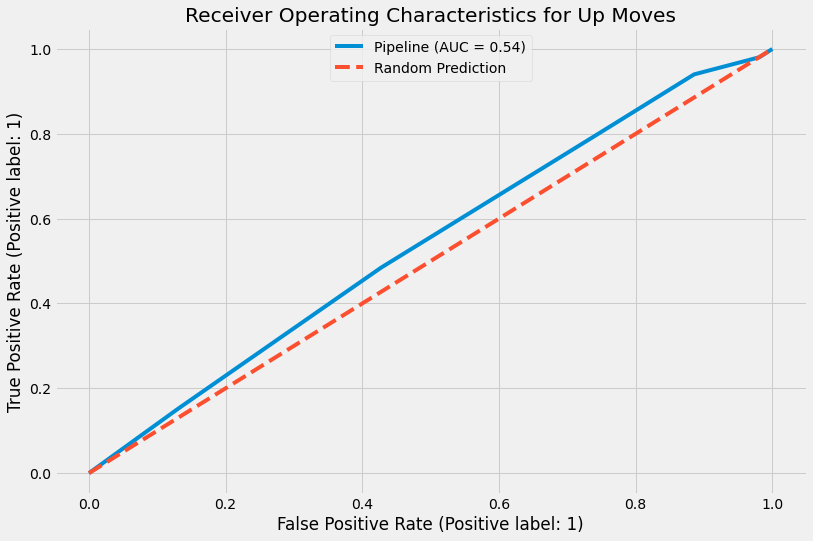

In [19]:
# ROC curve (TPR vs. FPR under different AUC)

# ramdom prediction
r_prob = [0 for _ in range(len(y_test))]
r_fpr, r_tpr, _ = roc_curve(y_test, r_prob, pos_label=1)
# plot roc curve
plot_roc_curve(pipe, X_test, y_test)
plt.plot(r_fpr, r_tpr, linestyle='dashed', label='Random Prediction')
plt.title('Receiver Operating Characteristics for Up Moves')
plt.legend(loc=9)
plt.show()

In [20]:
# corss validation of time series

# sample: 3 splits
tscv = TimeSeriesSplit(n_splits=3)
for train, test in tscv.split(X):
    print(train, test)

# cross validation for X
tscv = TimeSeriesSplit(n_splits=5)

[   0    1    2 ... 1410 1411 1412] [1413 1414 1415 ... 2820 2821 2822]
[   0    1    2 ... 2820 2821 2822] [2823 2824 2825 ... 4230 4231 4232]
[   0    1    2 ... 4230 4231 4232] [4233 4234 4235 ... 5640 5641 5642]


In [21]:
# gridsearch

# parameters of pipe
pipe.get_params()

{'memory': None,
 'steps': [('scaler', MinMaxScaler()), ('classifier', KNeighborsClassifier())],
 'verbose': False,
 'scaler': MinMaxScaler(),
 'classifier': KNeighborsClassifier(),
 'scaler__clip': False,
 'scaler__copy': True,
 'scaler__feature_range': (0, 1),
 'classifier__algorithm': 'auto',
 'classifier__leaf_size': 30,
 'classifier__metric': 'minkowski',
 'classifier__metric_params': None,
 'classifier__n_jobs': None,
 'classifier__n_neighbors': 5,
 'classifier__p': 2,
 'classifier__weights': 'uniform'}

In [22]:
# gridsearch and fit
param_grid = {"classifier__n_neighbors": np.arange(1,51,1)}

grid_search = GridSearchCV(pipe, param_grid, scoring='roc_auc', n_jobs=-1, cv=tscv, verbose=1) 
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                       ('classifier', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'classifier__n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50])},
             scoring='roc_auc', verbose=1)

In [23]:
# best Params
grid_search.best_params_

{'classifier__n_neighbors': 22}

In [24]:
# best score (auc: area under roc -> how well a model distinguish different classifications)
grid_search.best_score_

0.5440610779900981

In [25]:
# Elbow Method

error_rate = []
acc_score = []

for i in range(1,51):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))
    acc_score.append(accuracy_score(y_test, pred_i))

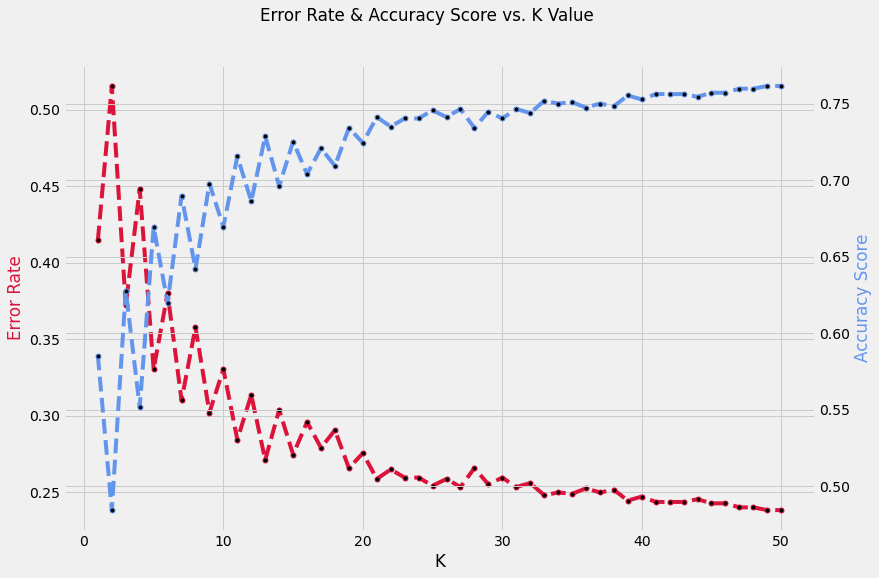

In [26]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(range(1,51), error_rate, color= 'crimson', linestyle='dashed',  marker='o', markerfacecolor='black', markersize=5)
ax2.plot(range(1,51), acc_score, color='cornflowerblue', linestyle='dashed', marker='o', markerfacecolor='black', markersize=5)

ax1.set_xlabel('K')
ax1.set_ylabel('Error Rate', color='crimson')
ax2.set_ylabel('Accuracy Score', color='cornflowerblue')

fig.suptitle('Error Rate & Accuracy Score vs. K Value');

In [27]:
# KNN model with grid_search param
clf = KNeighborsClassifier(n_neighbors = grid_search.best_params_['classifier__n_neighbors']) # 22
# fit the model
clf.fit(X_train, y_train)
# predict
y_pred = clf.predict(X_test)
# metrics
acc_train = accuracy_score(y_train, clf.predict(X_train))
acc_test = accuracy_score(y_test, y_pred)
print(f'\n Training Accuracy \t: {acc_train :0.4} \n Test Accuracy \t\t: {acc_test :0.4}')


 Training Accuracy 	: 0.7565 
 Test Accuracy 		: 0.7352


34 228 71 796


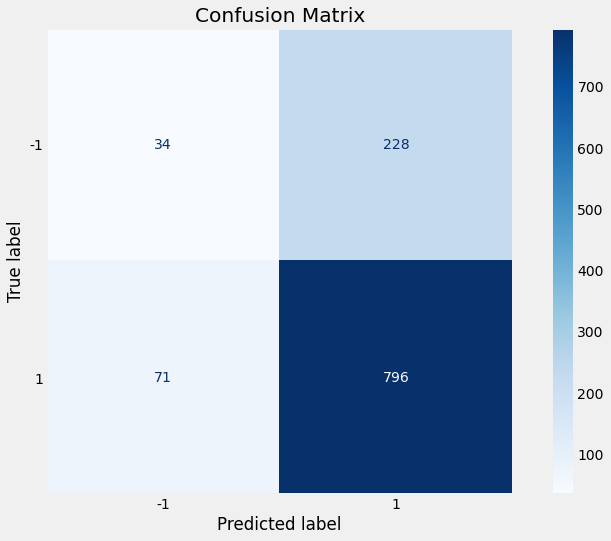

In [28]:
# confusion matrix (binary classification)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print(tn, fp, fn, tp)
# plot
plot_confusion_matrix(clf, X_test, y_test, cmap='Blues', values_format='.4g')
plt.title('Confusion Matrix')
plt.grid(False)

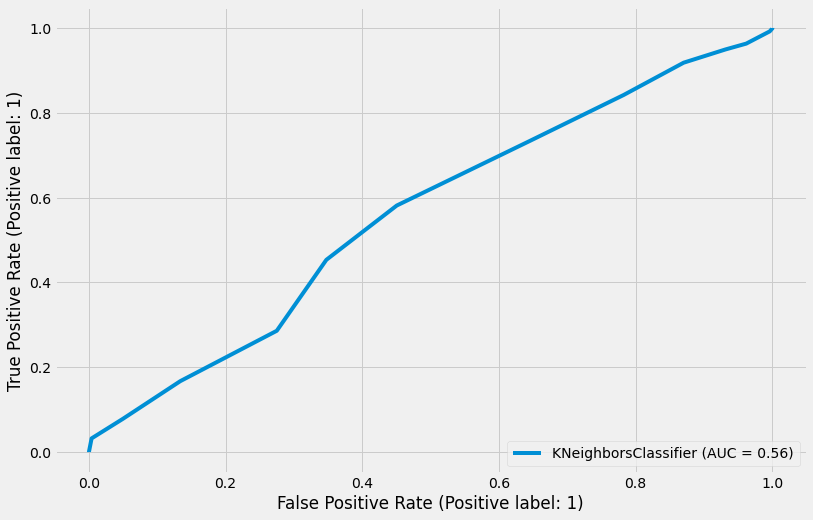

In [29]:
# plot ROC
plot_roc_curve(clf, X_test, y_test);

In [30]:
# classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.32      0.13      0.19       262
           1       0.78      0.92      0.84       867

    accuracy                           0.74      1129
   macro avg       0.55      0.52      0.51      1129
weighted avg       0.67      0.74      0.69      1129



In [31]:
# trading strategy

# covert to a new dataframe
df1 = df.copy()                      # df[-len(X_test)
df1['Signal'] = clf.predict(X)       # clf.predict(X_test)
# daily returns
df1['Returns'] = np.log(df1['Close']).diff().fillna(0)
# strategy returns: signal_t-1 * return_t
df1['Strategy'] = df1['Returns'] * df1['Signal'].shift(1).fillna(0)
# localize index for pyfolio, universal time zone
df1.index = df1.index.tz_localize('utc')
# check
df1.tail(5)

,Open,High,Low,Close,Adj Close,Volume,O-C,H-L,Signal,Returns,Strategy
Date,,,,,,,,,,,
2022-05-27 00:00:00+00:00,407.910004,415.380005,407.700012,415.260010,415.260010,84768700,-7.350006,7.679993,1,0.024253,0.024253
2022-05-31 00:00:00+00:00,413.549988,416.459991,410.029999,412.929993,412.929993,95937000,0.619995,6.429993,1,-0.005627,-0.005627
2022-06-01 00:00:00+00:00,415.170013,416.239990,406.929993,409.589996,409.589996,86585800,5.580017,9.309998,1,-0.008121,-0.008121
2022-06-02 00:00:00+00:00,409.420013,417.440002,407.040009,417.390015,417.390015,79609600,-7.970001,10.399994,1,0.018864,0.018864
2022-06-03 00:00:00+00:00,412.399994,414.040009,409.510010,410.540009,410.540009,71830800,1.859985,4.529999,-1,-0.016548,-0.016548


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,46.15,2000-03-23,2002-07-19,2005-11-21,1478
1,44.76,2007-10-09,2008-10-29,2009-09-10,503
2,16.72,2010-04-23,2010-07-02,2010-12-21,173
3,15.82,2022-01-03,2022-05-19,NaT,NaN
4,15.20,2011-02-18,2011-08-05,2011-08-29,137


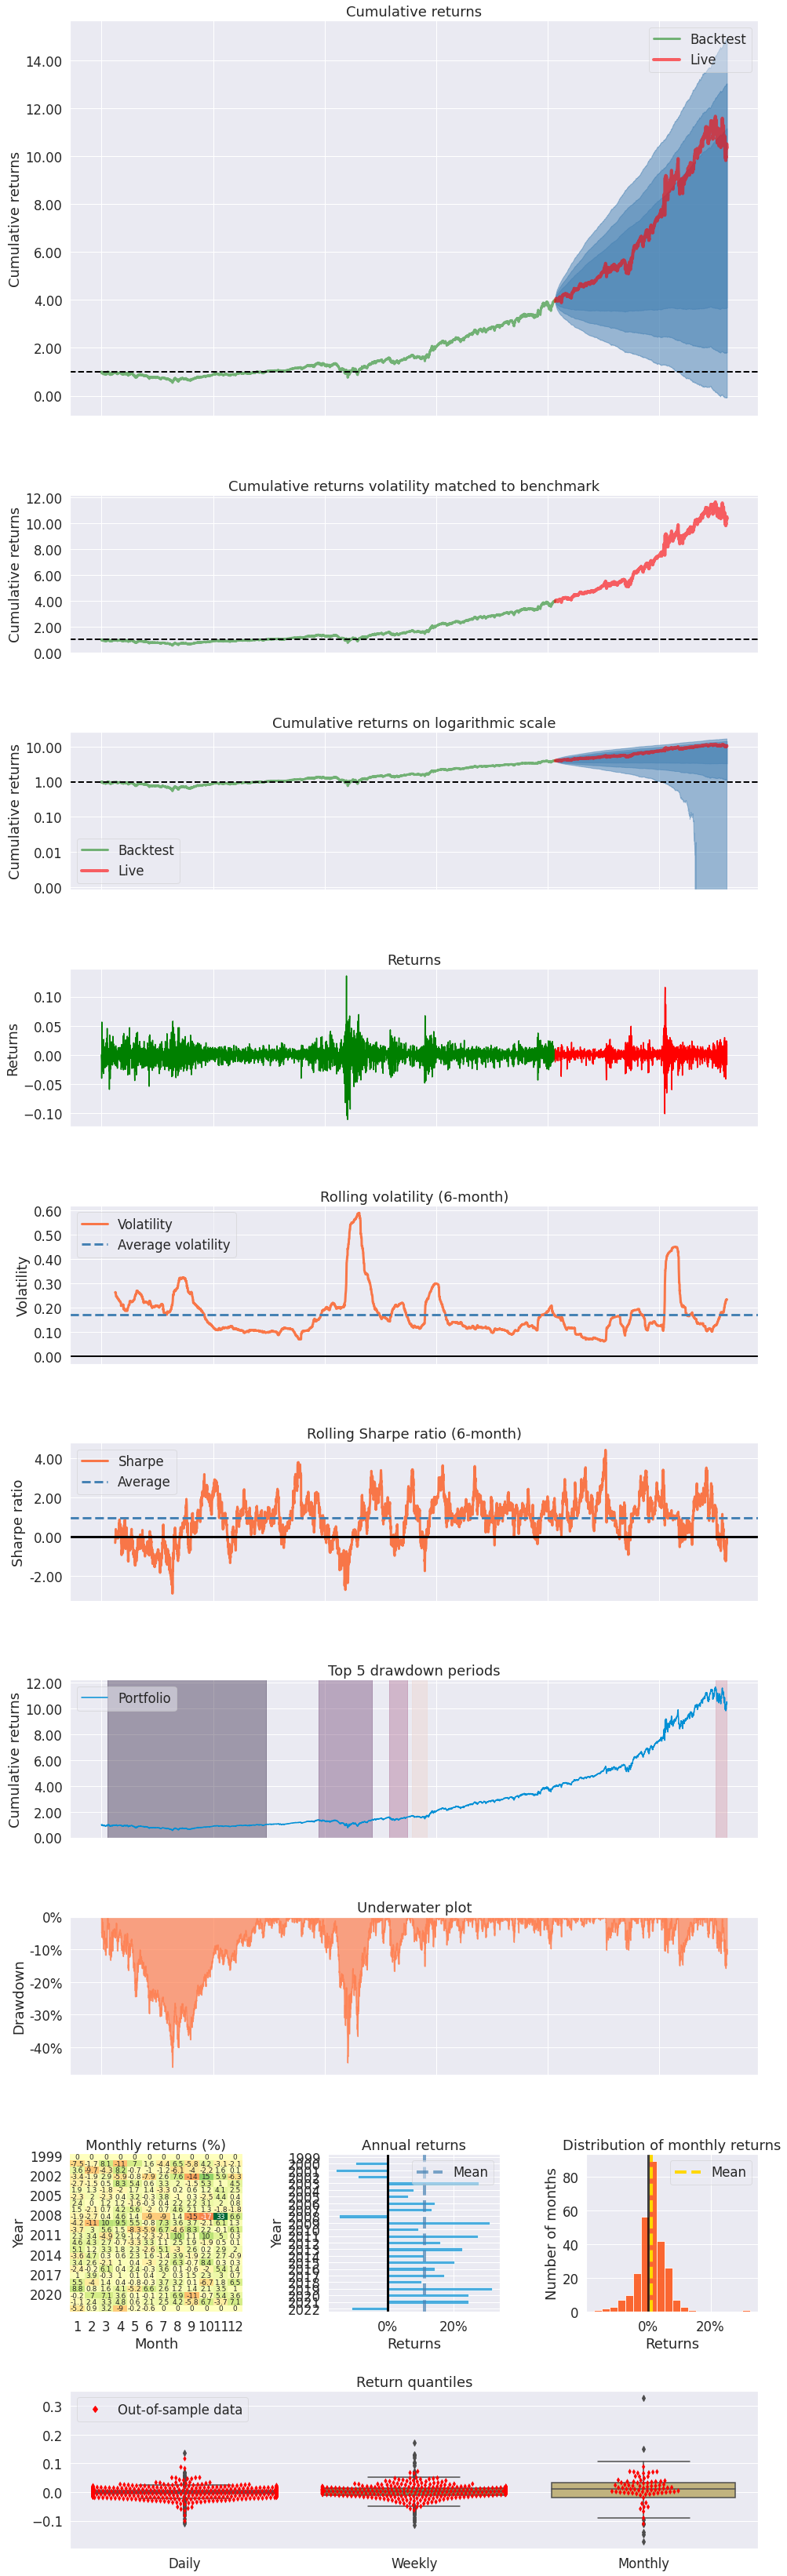

In [32]:
# return analysis
# create tear sheet for pyfolio outsample (X_test)
pf.create_returns_tear_sheet(df1['Strategy'], live_start_date='2016-04-07')